In [197]:
import random
import itertools
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import numpy as np

In [230]:
S = 0
I = 1
R = 2

# THESE LATER
V = 3 # Vaccinated
Q = 4 # Quarantined

# Major based sheduling?
# Should we model parties?

class Location:
    def __init__(self, infection_rate):
        self.infection_rate = infection_rate
        self.bucket = []
        
class Person:
    def __init__(self, state=S):
        self.state = state
        self.recovery_prob = 0.05

def gen_locations(num_locations, num_people):
    locs = []

    for i in range(num_locations):
        infection_rate = random.uniform(1e-3, 5e-3)
#         infection_rate = 3e-3
        loc = Location(infection_rate)
        locs.append(loc)
        
    for j in range(24):
        people = set(range(num_people))
        for loc in locs:
            if j < 8 or j > 19:
                loc.bucket.append([])
            else:
                samp = random.sample(list(people), k = num_people // num_locations)
                loc.bucket.append(samp)
                people -= set(samp)
    return locs

def gen_people(num_people, infected_proportion):
    ppl = []
    for _ in range(num_people):
        status = I if random.random() < infected_proportion else S
        person = Person(status)
        ppl.append(person)
    return ppl

def people_with_state(bucket, people, state):
    return filter(lambda id: people[id].state == state, bucket)

def infection_pairs(bucket, people):
    infected    = people_with_state(bucket, people, I)
    susceptible = people_with_state(bucket, people, S)
    return itertools.product(infected, susceptible)

def find_new_infections(location, people, time):
    for p1, p2 in infection_pairs(location.bucket[time], people):
        if random.random() < location.infection_rate:
            yield p2

def count_state(people, state):
    return float(sum(person.state == state for person in people))

def count_states(people):
    return [count_state(people, state) for state in (S, I, R)]

def simulate(locations, people, num_days):
    counts = [count_states(people)]
    for day in range(num_days):
        # Find Infections
        new_infections = []
        for time in range(24):
            for location in locations:
                for person_id in find_new_infections(location, people, time):
                    if person_id not in new_infections:
                        new_infections.append(person_id)
        # Set Infections
        for person_id in new_infections:
            people[person_id].state = I
        # Handle Recovery
        for person in people:
            if person.state == I and random.random() < person.recovery_prob:
                person.state = R
        # Get Counts
        counts.append(count_states(people))
    return np.array(counts)

In [231]:
def basic_sir_step(count, infection_rate, recovery_rate):
    S, I, R = count
    return np.array([S - infection_rate * S * I,
                     I + infection_rate * S * I - recovery_rate * I,
                     R + recovery_rate * I])

def basic_sir(counts, infection_rate, recovery_rate):
    n = len(counts)
    new_counts = np.zeros((n, 3))
    for i in range(n):
        new_counts[i] = basic_sir_step(counts[i], infection_rate, recovery_rate)
    return new_counts.flatten()

def fit_params(counts):
    xdata = counts[:-1]
    ydata = counts[1:].flatten()
    popt, pcov = curve_fit(basic_sir, xdata, ydata)
    return popt

def basic_sir_simulate(start_count, infection_rate, recovery_rate, num_days):
    counts = [start_count]
    for _ in range(num_days):
        new_count = basic_sir_step(counts[-1], infection_rate, recovery_rate)
        counts.append(new_count)
    return counts

0.0030753527219589127 0.05248247853379806


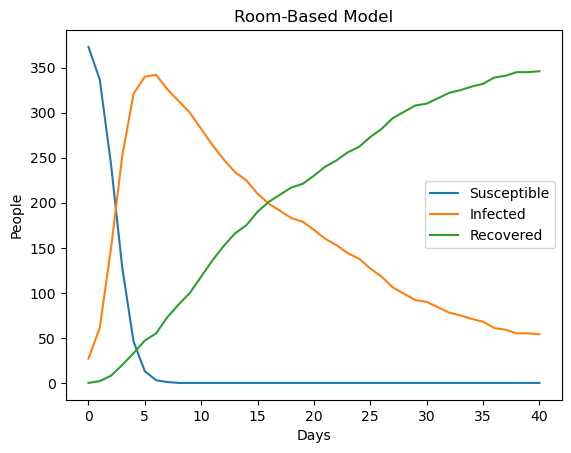

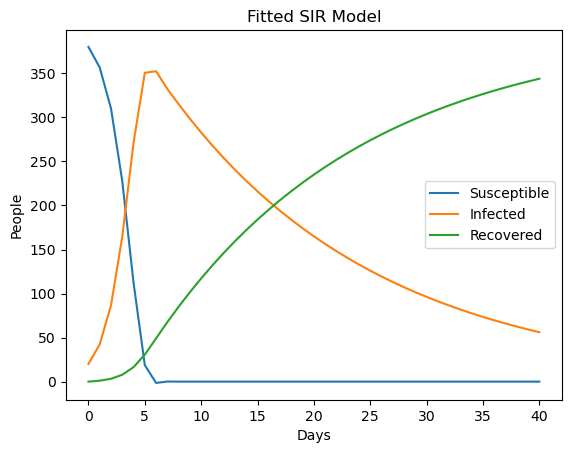

In [246]:
def plot_counts(counts, title, filename):
    fig, ax = plt.subplots()
    ax.set_xlabel("Days")
    ax.set_ylabel("People")
    ax.plot(counts)
    ax.legend(["Susceptible", "Infected", "Recovered"])
    ax.set_title(title)
    fig.savefig(filename)

# In our initial model people got infected really fast but recovered really fast

# NUM_LOCS = 10
# NUM_PEOPLE = 400
# NUM_DAYS = 40
# INFECTED_PROPORTION = 1/20

def run_simulation(num_locs, num_people, num_days, infected_proportion):
    locations = gen_locations(num_locs, num_people)
    ppl = gen_people(num_people, infected_proportion)
    return simulate(locations, ppl, NUM_DAYS)

counts = run_simulation(10, 400, 40, 1/20)
plot_counts(counts, "Room-Based Model", "room-based.png")

infection_rate, recovery_rate = fit_params(counts)
start_count = [(1-INFECTED_PROPORTION) * NUM_PEOPLE,
               INFECTED_PROPORTION * NUM_PEOPLE,
               0]
new_counts = basic_sir_simulate(start_count, infection_rate, recovery_rate, NUM_DAYS)
plot_counts(new_counts, "Fitted SIR Model", "sir-fit.png")
print(infection_rate, recovery_rate)



In [ ]:
def estimate_rates(num_locs, num_people, num_days, infected_proportion):
    counts = run_simulation(num_locs, num_people, num_days, infected_proportion)
    infection_rate, recovery_rate = fit_params(counts)
    return infection_rate, recovery_rate

results = [estimate_rates(num_locs, 400, 40, 1/20) for num_locs in range(1, 100)]
infection_rates = [result[0] for result in results]
recovery_rates = [result[1] for result in results]

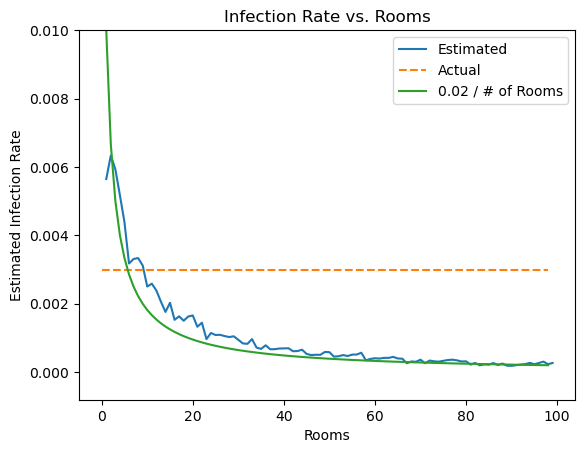

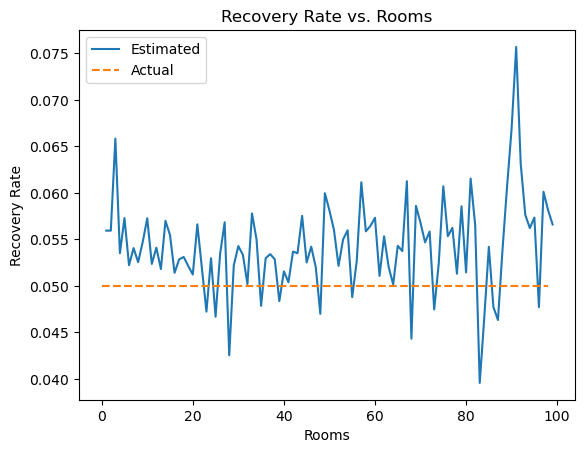

In [249]:
fig, ax = plt.subplots()
ax.set_xlabel("Rooms")
ax.set_ylabel("Estimated Infection Rate")
ax.plot(range(1, 100), infection_rates)
ax.plot([0.003 for _ in range(len(results))], linestyle="dashed")
ax.plot([0.02 / i for i in range(1, 100)])
ax.set_ylim(top=0.01)
ax.legend(["Estimated", "Actual", "0.02 / # of Rooms"])
ax.set_title("Infection Rate vs. Rooms")
fig.savefig("infection-rate.png")

fig, ax = plt.subplots()
ax.set_xlabel("Rooms")
ax.set_ylabel("Recovery Rate")
ax.plot(range(1, 100), recovery_rates)
ax.plot([0.05 for _ in range(len(results))], linestyle="dashed")
ax.legend(["Estimated", "Actual"])
ax.set_title("Recovery Rate vs. Rooms")
fig.savefig("recovery-rate.png")